In [1]:
import pandas as pd
import sklearn.mixture as mix

import numpy as np
import networkx as nx
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
from tqdm import tqdm
from pprint import pprint

In [2]:
def get_markov_edges(Q):
    """Function that maps transition probability dataframe to markov edges and weights.
    """
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx, col)] = Q.loc[idx, col]
    return edges

In [3]:
def viterbi(pi, a, b, obs):
    """Define Viterbi algorithm for shortest path.

    Code adapted from Stephen Marsland's, Machine Learning An Algorthmic Perspective, Vol. 2
    https://github.com/alexsosn/MarslandMLAlgo/blob/master/Ch16/HMM.py
    """

    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    # init blank path
    path = np.zeros(T)
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    print('\nStart Walk Forward\n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    print('-'*50)
    print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[int(path[t+1]), t+1]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

## Create state space and initial state probabilities

In [4]:
states = ['sleeping', 'eating', 'pooping']
pi = [0.35, 0.35, 0.3]
state_space = pd.Series(pi, index=states, name='states')
print(state_space)
print(state_space.sum())

sleeping    0.35
eating      0.35
pooping     0.30
Name: states, dtype: float64
1.0


## Create transition matrix
transition matrix equals transition probability matrix of changing states given a state matrix is size (M x M) where M is number of states.

In [5]:
q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.4, 0.2, 0.4]
q_df.loc[states[1]] = [0.45, 0.45, 0.1]
q_df.loc[states[2]] = [0.45, 0.25, .3]

print(q_df)

q = q_df.values
print('\n', q, '\n')
print(q_df.sum(axis=1))

         sleeping eating pooping
sleeping      0.4    0.2     0.4
eating       0.45   0.45     0.1
pooping      0.45   0.25     0.3

 [[0.4 0.2 0.4]
 [0.45 0.45 0.1]
 [0.45 0.25 0.3]] 

sleeping    1.0
eating      1.0
pooping     1.0
dtype: float64


In [6]:
edges_wts = get_markov_edges(q_df)
for key, val in edges_wts.items():
    print("%25s : %.2f" % (key, val))

 ('sleeping', 'sleeping') : 0.40
   ('eating', 'sleeping') : 0.45
  ('pooping', 'sleeping') : 0.45
   ('sleeping', 'eating') : 0.20
     ('eating', 'eating') : 0.45
    ('pooping', 'eating') : 0.25
  ('sleeping', 'pooping') : 0.40
    ('eating', 'pooping') : 0.10
   ('pooping', 'pooping') : 0.30


Nodes:
['sleeping', 'eating', 'pooping']

Edges:
OutMultiEdgeDataView([('sleeping', 'sleeping', {'weight': 0.4, 'label': 0.4}), ('sleeping', 'eating', {'weight': 0.2, 'label': 0.2}), ('sleeping', 'pooping', {'weight': 0.4, 'label': 0.4}), ('eating', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('eating', 'eating', {'weight': 0.45, 'label': 0.45}), ('eating', 'pooping', {'weight': 0.1, 'label': 0.1}), ('pooping', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('pooping', 'eating', {'weight': 0.25, 'label': 0.25}), ('pooping', 'pooping', {'weight': 0.3, 'label': 0.3})])


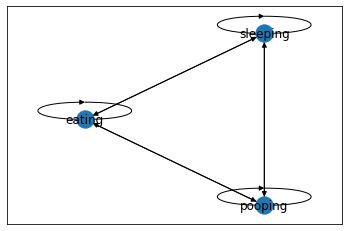

In [7]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(G.edges(data=True))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

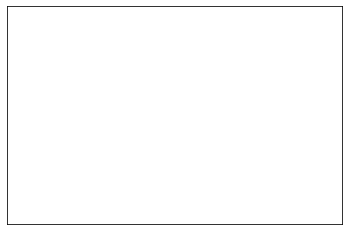

In [25]:
# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1, n2): d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')

## Create state space and initial state probabilities

In [9]:
hidden_states = ['healthy', 'sick']
pi = [0.5, 0.5]
state_space = pd.Series(pi, index=hidden_states, name='states')
print(state_space)
print('\n', state_space.sum())

healthy    0.5
sick       0.5
Name: states, dtype: float64

 1.0


## Create hidden transition matrix
a or alpha = transition probability matrix of changing states given a state matrix is size (M x M) where M is number of states.

In [10]:
a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]

print(a_df)

a = a_df.values
print('\n', a, '\n')
print(a_df.sum(axis=1))

        healthy sick
healthy     0.7  0.3
sick        0.4  0.6

 [[0.7 0.3]
 [0.4 0.6]] 

healthy    1.0
sick       1.0
dtype: float64


## Create matrix of observation (emission) probabilities
b or beta = observation probabilities given state matrix is size (M x O) where M is number of states and O is number of different possible observations

In [11]:
observable_states = states

b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.2, 0.6, 0.2]
b_df.loc[hidden_states[1]] = [0.4, 0.1, 0.5]

print(b_df)

b = b_df.values
print('\n', b, b.shape, '\n')
print(b_df.sum(axis=1))

        sleeping eating pooping
healthy      0.2    0.6     0.2
sick         0.4    0.1     0.5

 [[0.2 0.6 0.2]
 [0.4 0.1 0.5]] (2, 3) 

healthy    1.0
sick       1.0
dtype: float64


In [12]:
# create graph edges and weights
hide_edges_wts = get_markov_edges(a_df)
for key, val in hide_edges_wts.items():
    print("%25s : %.2f" % (key, val))

print()

emit_edges_wts = get_markov_edges(b_df)
for key, val in emit_edges_wts.items():
    print("%25s : %.2f" % (key, val))

   ('healthy', 'healthy') : 0.70
      ('sick', 'healthy') : 0.40
      ('healthy', 'sick') : 0.30
         ('sick', 'sick') : 0.60

  ('healthy', 'sleeping') : 0.20
     ('sick', 'sleeping') : 0.40
    ('healthy', 'eating') : 0.60
       ('sick', 'eating') : 0.10
   ('healthy', 'pooping') : 0.20
      ('sick', 'pooping') : 0.50


Nodes:
['healthy', 'sick']

Edges:
OutMultiEdgeDataView([('healthy', 'healthy', {'weight': 0.7, 'label': 0.7}), ('healthy', 'sick', {'weight': 0.3, 'label': 0.3}), ('healthy', 'sleeping', {'weight': 0.2, 'label': 0.2}), ('healthy', 'eating', {'weight': 0.6, 'label': 0.6}), ('healthy', 'pooping', {'weight': 0.2, 'label': 0.2}), ('sick', 'healthy', {'weight': 0.4, 'label': 0.4}), ('sick', 'sick', {'weight': 0.6, 'label': 0.6}), ('sick', 'sleeping', {'weight': 0.4, 'label': 0.4}), ('sick', 'eating', {'weight': 0.1, 'label': 0.1}), ('sick', 'pooping', {'weight': 0.5, 'label': 0.5})])


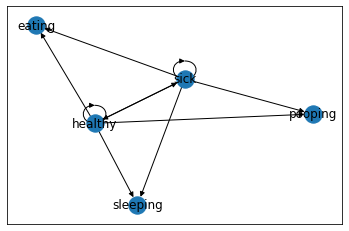

In [13]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(hidden_states)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent hidden probabilities
for k, v in hide_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

# edges represent emission probabilities
for k, v in emit_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

print(f'Edges:')
pprint(G.edges(data=True))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos)

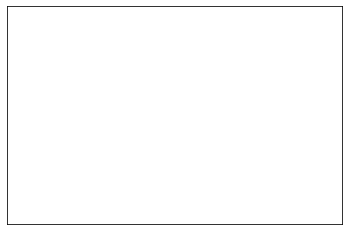

In [14]:
# create edge labels for jupyter plot but is not necessary
emit_edge_labels = {(n1, n2): d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=emit_edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_hidden_markov.dot')

## Observation sequence of dog's behaviors
observations are encoded numerically

In [15]:
obs_map = {'sleeping': 0, 'eating': 1, 'pooping': 2}
obs = np.array([1, 1, 2, 1, 0, 1, 2, 1, 0, 2, 2, 0, 1, 0, 1])

inv_obs_map = dict((v, k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print(pd.DataFrame(
    np.column_stack([obs, obs_seq]),
    columns=['Obs_code', 'Obs_seq']
))

   Obs_code   Obs_seq
0         1    eating
1         1    eating
2         2   pooping
3         1    eating
4         0  sleeping
5         1    eating
6         2   pooping
7         1    eating
8         0  sleeping
9         2   pooping
10        2   pooping
11        0  sleeping
12        1    eating
13        0  sleeping
14        1    eating


In [16]:
path, delta, phi = viterbi(pi, a, b, obs)
print("Single best state path: \n", path)


Start Walk Forward

s=0 and t=1: phi[0, 1] = 0.0
s=1 and t=1: phi[1, 1] = 0.0
s=0 and t=2: phi[0, 2] = 0.0
s=1 and t=2: phi[1, 2] = 0.0
s=0 and t=3: phi[0, 3] = 0.0
s=1 and t=3: phi[1, 3] = 1.0
s=0 and t=4: phi[0, 4] = 0.0
s=1 and t=4: phi[1, 4] = 0.0
s=0 and t=5: phi[0, 5] = 0.0
s=1 and t=5: phi[1, 5] = 1.0
s=0 and t=6: phi[0, 6] = 0.0
s=1 and t=6: phi[1, 6] = 0.0
s=0 and t=7: phi[0, 7] = 0.0
s=1 and t=7: phi[1, 7] = 1.0
s=0 and t=8: phi[0, 8] = 0.0
s=1 and t=8: phi[1, 8] = 0.0
s=0 and t=9: phi[0, 9] = 0.0
s=1 and t=9: phi[1, 9] = 1.0
s=0 and t=10: phi[0, 10] = 1.0
s=1 and t=10: phi[1, 10] = 1.0
s=0 and t=11: phi[0, 11] = 1.0
s=1 and t=11: phi[1, 11] = 1.0
s=0 and t=12: phi[0, 12] = 1.0
s=1 and t=12: phi[1, 12] = 1.0
s=0 and t=13: phi[0, 13] = 0.0
s=1 and t=13: phi[1, 13] = 0.0
s=0 and t=14: phi[0, 14] = 0.0
s=1 and t=14: phi[1, 14] = 1.0
--------------------------------------------------
Start Backtrace

path[13] = 0.0
path[12] = 0.0
path[11] = 1.0
path[10] = 1.0
path[9] = 1.0
path[

In [17]:
print("delta:\n", delta)

delta:
 [[3.00000000e-01 1.26000000e-01 1.76400000e-02 7.40880000e-03
  1.03723200e-03 4.35637440e-04 6.09892416e-05 2.56154815e-05
  3.58616741e-06 5.02063437e-07 7.37725866e-08 2.21317760e-08
  1.59348787e-08 2.23088302e-09 9.36970868e-10]
 [5.00000000e-02 9.00000000e-03 1.89000000e-02 1.13400000e-03
  8.89056000e-04 5.33433600e-05 6.53456160e-05 3.92073696e-06
  3.07385778e-06 9.22157333e-07 2.76647200e-07 6.63953280e-08
  3.98371968e-09 1.91218545e-09 1.14731127e-10]]


In [18]:
print("phi:\n", phi)

phi:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.]]


## Result

In [19]:
state_map = {
    0: 'healthy',
    1: 'sick'
}
state_path = [state_map[v] for v in path]

(pd.DataFrame().assign(Observation=obs_seq).assign(Best_Path=state_path))

,Observation,Best_Path
0,eating,healthy
1,eating,healthy
2,pooping,healthy
3,eating,healthy
4,sleeping,healthy
5,eating,healthy
6,pooping,healthy
7,eating,healthy
8,sleeping,sick
9,pooping,sick
